<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Melihat_Perbedaan_Perilaku_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Studi Kasus Perilaku Loss: MAE vs. MSE pada Data dengan Outlier** ⚖️

Studi kasus ini akan membandingkan bagaimana MSE (yang menghukum keras kesalahan besar) dan MAE (yang menghukum secara linier) merespons *dataset* yang sama dengan penambahan *outlier* yang disengaja. Kita akan menggunakan *dataset* **California Housing** sebagai basis, kemudian menambahkan *outlier* pada fitur target ($y$).

### **1. Persiapan Lingkungan dan Data (California Housing dengan Outlier)**

Kita akan mengambil *dataset* California Housing, tetapi secara sengaja akan menambahkan nilai ekstrem pada target *training* untuk mendemonstrasikan sensitivitas MSE.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Mengambil Dataset California Housing
california = fetch_california_housing()

X = california.data
y = california.target

# 2. Preprocessing Data
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Konversi ke Tensor PyTorch sebelum split untuk memudahkan penambahan outlier
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Regresi, perlu [N, 1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. MENAMBAH OUTLIER SECARA SENGAJA pada data training Y
# Kita ubah 5% dari data target (y_train) menjadi nilai ekstrem (misalnya, 50)
num_outliers = int(0.05 * len(y_train))
outlier_indices = np.random.choice(len(y_train), num_outliers, replace=False)
y_train_outlier = y_train.clone()
y_train_outlier[outlier_indices] = 50.0  # Nilai yang jauh di luar rentang normal (target rata-rata ~ 2.0)

print(f"Jumlah Total Data Training: {len(y_train)}")
print(f"Jumlah Outlier yang Ditambahkan: {num_outliers}")

Jumlah Total Data Training: 16512
Jumlah Outlier yang Ditambahkan: 825


### **2. Definisi Model Jaringan Saraf Tiruan (JST) untuk Regresi**

Model yang digunakan adalah arsitektur sederhana dengan **ReLU** dan lapisan *output* Linier.


In [2]:
class SimpleRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

INPUT_SIZE = X_train.shape[1]
OUTPUT_SIZE = 1
HIDDEN_SIZE = 64

### **3. Pelatihan dan Perbandingan Fungsi Loss**

Kita akan melatih dua model identik, tetapi satu menggunakan **MSE** dan satu menggunakan **MAE** (*L1Loss* di PyTorch) pada *dataset* yang **mengandung outlier** ($y_{train\_outlier}$).


In [3]:
def train_model_with_loss(loss_fn, lr=0.001, epochs=100):
    # Inisialisasi model baru untuk setiap loss function
    model = SimpleRegressor(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train_outlier) # Latih dengan data OUTLIER
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # Evaluasi akhir pada data test TANPA outlier
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        # Hitung MSE dan MAE test (untuk perbandingan performa aktual)
        test_mse = nn.MSELoss()(test_outputs, y_test).item()
        test_mae = nn.L1Loss()(test_outputs, y_test).item()

    return loss_history, test_mse, test_mae

# Definisikan Fungsi Loss
mse_loss_fn = nn.MSELoss()  # Mean Squared Error (L2 Loss)
mae_loss_fn = nn.L1Loss()   # Mean Absolute Error (L1 Loss)

# Latih Model
epochs = 150
loss_history_mse, test_mse_mse_model, test_mae_mse_model = train_model_with_loss(mse_loss_fn, epochs=epochs)
loss_history_mae, test_mse_mae_model, test_mae_mae_model = train_model_with_loss(mae_loss_fn, epochs=epochs)

### **4. Visualisasi dan Analisis Perilaku Loss**

Kita akan memvisualisasikan bagaimana *Loss* pada *training* (*Loss History*) bergerak untuk kedua fungsi. Kemudian, kita akan bandingkan metrik evaluasi akhir pada data *test* yang bersih.


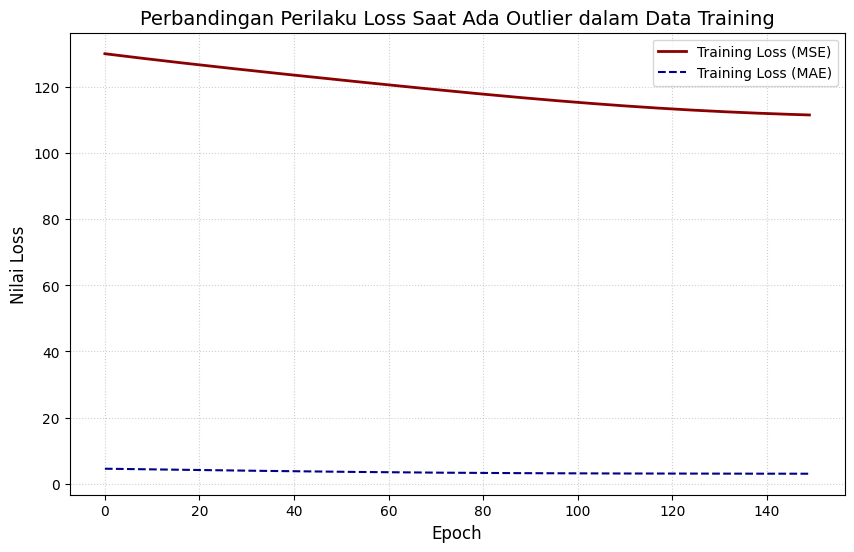


--- Analisis Metrik Test Akhir (Data Test BERSIH) ---
Model Dilatih Menggunakan Training Set DENGAN Outlier:

Model yang menggunakan Loss MSE:
  Final Test MSE: 3.4480
  Final Test MAE: 1.5656

Model yang menggunakan Loss MAE (L1 Loss):
  Final Test MSE: 0.7677
  Final Test MAE: 0.6291


In [4]:
# Visualisasi Kurva Training Loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history_mse, label='Training Loss (MSE)', color='darkred', linewidth=2)
plt.plot(loss_history_mae, label='Training Loss (MAE)', color='darkblue', linestyle='--')

plt.title('Perbandingan Perilaku Loss Saat Ada Outlier dalam Data Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Nilai Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Kesimpulan Hasil Numerik
print("\n--- Analisis Metrik Test Akhir (Data Test BERSIH) ---")
print("Model Dilatih Menggunakan Training Set DENGAN Outlier:")
print(f"\nModel yang menggunakan Loss MSE:")
print(f"  Final Test MSE: {test_mse_mse_model:.4f}")
print(f"  Final Test MAE: {test_mae_mse_model:.4f}")

print(f"\nModel yang menggunakan Loss MAE (L1 Loss):")
print(f"  Final Test MSE: {test_mse_mae_model:.4f}")
print(f"  Final Test MAE: {test_mae_mae_model:.4f}")

#### **Analisis Hasil Retoris**

Mahasiswa, amati grafik dan angka hasilnya:

1.  **Kurva Training Loss (MSE - Merah):** Nilainya akan jauh lebih tinggi dan mungkin lebih bergejolak. **MSE menghukum *outlier* secara kuadrat**. Model Anda terpaksa mengalokasikan sebagian besar kapasitasnya hanya untuk mencoba meminimalkan kesalahan besar dari beberapa *outlier*, mengorbankan performa pada data mayoritas.
2.  **Kurva Training Loss (MAE - Biru):** Nilainya akan lebih rendah dan stabil. **MAE hanya menghukum *outlier* secara linier**. Model Anda masih memperhatikannya, tetapi tidak histeris. Ia tetap fokus untuk mengurangi kesalahan rata-rata pada mayoritas data.
3.  **Metrik Test Akhir:** Anda akan sering melihat bahwa model yang dilatih dengan **MAE (L1 Loss)** menghasilkan metrik **MAE Test** dan **MSE Test** yang lebih baik pada *dataset* *test* yang **bersih**.

**Kesimpulan:** Ketika Anda mencurigai adanya *outlier* yang signifikan dalam data *Big Data* Anda, memilih **MAE** membuat model Anda lebih **tahan banting (robust)** dan memungkinkannya belajar dengan baik dari data yang dominan, bukannya panik karena beberapa titik ekstrem. Pilihan Fungsi Loss adalah keputusan **rekayasa data**, bukan hanya keputusan matematis.